[I 2024-11-18 17:08:19,161] A new study created in memory with name: no-name-c35cee3f-0961-4ee2-951f-a5def7a97124
[I 2024-11-18 17:08:36,470] Trial 0 finished with value: 0.65125 and parameters: {'hidden_channels': 66, 'num_layers': 4, 'dropout': 0.2607892972226862, 'learning_rate': 0.0002640444539134602, 'weight_decay': 7.974775859463197e-05}. Best is trial 0 with value: 0.65125.
[I 2024-11-18 17:08:50,965] Trial 1 finished with value: 0.67125 and parameters: {'hidden_channels': 56, 'num_layers': 3, 'dropout': 0.34396005366160154, 'learning_rate': 0.00010479749086350717, 'weight_decay': 2.0086509949626275e-05}. Best is trial 1 with value: 0.67125.
[I 2024-11-18 17:09:09,348] Trial 2 finished with value: 0.69625 and parameters: {'hidden_channels': 125, 'num_layers': 4, 'dropout': 0.17765268417801067, 'learning_rate': 0.0032867402147578337, 'weight_decay': 2.0292480283141096e-06}. Best is trial 2 with value: 0.69625.
[I 2024-11-18 17:09:29,827] Trial 3 finished with value: 0.62375 and p

Best hyperparameters: {'hidden_channels': 125, 'num_layers': 4, 'dropout': 0.17765268417801067, 'learning_rate': 0.0032867402147578337, 'weight_decay': 2.0292480283141096e-06}
Epoch: 000, Train Loss: 0.6802, Train Accuracy: 0.5631, Test Loss: 0.6540, Test Accuracy: 0.5950, ROC AUC: 0.7095937499999999, F1: 0.4471, Kappa: 0.1900, Precision: 0.7043, Recall: 0.3275
Epoch: 001, Train Loss: 0.6435, Train Accuracy: 0.6184, Test Loss: 0.6330, Test Accuracy: 0.6188, ROC AUC: 0.7098437500000001, F1: 0.5495, Kappa: 0.2375, Precision: 0.6715, Recall: 0.4650
Epoch: 002, Train Loss: 0.6228, Train Accuracy: 0.6553, Test Loss: 0.6204, Test Accuracy: 0.6412, ROC AUC: 0.712475, F1: 0.6306, Kappa: 0.2825, Precision: 0.6499, Recall: 0.6125
Epoch: 003, Train Loss: 0.6222, Train Accuracy: 0.6522, Test Loss: 0.6306, Test Accuracy: 0.6663, ROC AUC: 0.7115875, F1: 0.7192, Kappa: 0.3325, Precision: 0.6207, Recall: 0.8550
Epoch: 004, Train Loss: 0.6230, Train Accuracy: 0.6628, Test Loss: 0.6202, Test Accuracy: 0

Epoch: 045, Train Loss: 0.5739, Train Accuracy: 0.7059, Test Loss: 0.5835, Test Accuracy: 0.6900, ROC AUC: 0.7908, F1: 0.7395, Kappa: 0.3800, Precision: 0.6377, Recall: 0.8800
Epoch: 046, Train Loss: 0.5696, Train Accuracy: 0.6991, Test Loss: 0.5643, Test Accuracy: 0.7300, ROC AUC: 0.7941374999999999, F1: 0.7266, Kappa: 0.4600, Precision: 0.7359, Recall: 0.7175
Epoch: 047, Train Loss: 0.5713, Train Accuracy: 0.7125, Test Loss: 0.5696, Test Accuracy: 0.7137, ROC AUC: 0.7783937499999999, F1: 0.7296, Kappa: 0.4275, Precision: 0.6913, Recall: 0.7725
Epoch: 048, Train Loss: 0.5684, Train Accuracy: 0.7137, Test Loss: 0.5467, Test Accuracy: 0.7362, ROC AUC: 0.8032062500000001, F1: 0.7242, Kappa: 0.4725, Precision: 0.7589, Recall: 0.6925
Epoch: 049, Train Loss: 0.5615, Train Accuracy: 0.7109, Test Loss: 0.5905, Test Accuracy: 0.6800, ROC AUC: 0.7552999999999999, F1: 0.6684, Kappa: 0.3600, Precision: 0.6935, Recall: 0.6450
Epoch: 050, Train Loss: 0.5640, Train Accuracy: 0.7141, Test Loss: 0.559

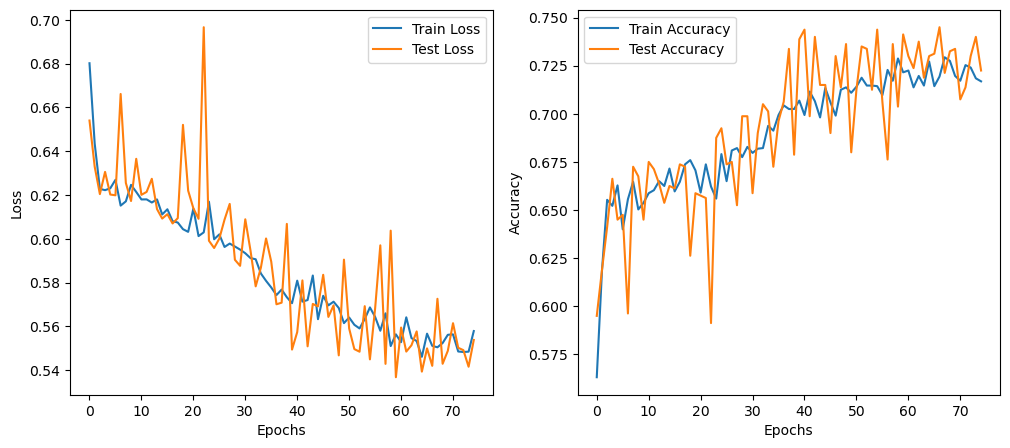

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
from torch_geometric.loader import DataLoader
from torch_geometric.utils import from_smiles
from torch_geometric.nn import GCNConv, global_mean_pool
from sklearn.metrics import roc_auc_score, f1_score, cohen_kappa_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
import optuna
import os
import random

# Set random seed for reproducibility
def seed_set(seed=50):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)

seed_set()

# Define device (CPU or GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load your dataset
df_final = pd.read_csv('AID932_data_for_classification_08Nov2024.csv')

# Preprocess data and create graph list
graph_list = []
for i, smile in enumerate(df_final['SMILES']):
    try:
        g = from_smiles(smile)
        g.x = g.x.float()
        y_value = 1.0 if df_final['PUBCHEM_ACTIVITY_OUTCOME'][i] == 'Active' else 0.0
        y = torch.tensor(y_value, dtype=torch.float).view(1, -1)
        g.y = y
        graph_list.append(g)
    except Exception as e:
        print(f"Error processing SMILES {smile}: {e}")
        continue

# Stratified split of dataset into train and test sets
labels = [g.y.item() for g in graph_list]
train_dataset, test_dataset = train_test_split(graph_list, test_size=0.2, stratify=labels, random_state=50)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Define GCN model
class GCN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, num_layers, dropout):
        super(GCN, self).__init__()
        self.convs = torch.nn.ModuleList()
        self.convs.append(GCNConv(in_channels, hidden_channels))
        for _ in range(num_layers - 2):
            self.convs.append(GCNConv(hidden_channels, hidden_channels))
        self.convs.append(GCNConv(hidden_channels, out_channels))
        self.dropout = dropout

    def forward(self, x, edge_index, batch):
        for conv in self.convs[:-1]:
            x = conv(x, edge_index)
            x = F.relu(x)
            x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.convs[-1](x, edge_index)
        x = global_mean_pool(x, batch)
        return torch.sigmoid(x)

# Training function
def train(model, loader, optimizer):
    model.train()
    total_loss = 0
    correct = 0
    for data in loader:
        data = data.to(device)
        optimizer.zero_grad()
        out = model(data.x, data.edge_index, data.batch)
        loss = F.binary_cross_entropy(out, data.y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * data.num_graphs
        pred = (out > 0.5).float()
        correct += pred.eq(data.y).sum().item()
    return total_loss / len(loader.dataset), correct / len(loader.dataset)

# Testing function
def test(model, loader):
    model.eval()
    total_loss = 0
    correct = 0
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for data in loader:
            data = data.to(device)
            out = model(data.x, data.edge_index, data.batch)
            loss = F.binary_cross_entropy(out, data.y)
            total_loss += loss.item() * data.num_graphs
            pred = (out > 0.5).float()
            correct += pred.eq(data.y).sum().item()

            all_preds.extend(out.cpu().numpy().flatten())
            all_labels.extend(data.y.cpu().numpy().flatten())

    loss = total_loss / len(loader.dataset)
    accuracy = correct / len(loader.dataset)

    if len(np.unique(all_labels)) < 2:
        roc_auc = None
    else:
        roc_auc = roc_auc_score(all_labels, all_preds)

    f1 = f1_score(all_labels, np.round(all_preds))
    kappa = cohen_kappa_score(all_labels, np.round(all_preds))
    precision = precision_score(all_labels, np.round(all_preds))
    recall = recall_score(all_labels, np.round(all_preds))

    return loss, accuracy, roc_auc, f1, kappa, precision, recall

# Optuna objective function for hyperparameter optimization
def objective(trial):
    hidden_channels = trial.suggest_int("hidden_channels", 32, 128)
    num_layers = trial.suggest_int("num_layers", 2, 5)
    dropout = trial.suggest_float("dropout", 0.1, 0.5)
    learning_rate = trial.suggest_float("learning_rate", 1e-4, 1e-2, log=True)
    weight_decay = trial.suggest_float("weight_decay", 1e-6, 1e-4, log=True)

    model = GCN(in_channels=9, hidden_channels=hidden_channels, out_channels=1,
                num_layers=num_layers, dropout=dropout).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

    for epoch in range(20):
        train_loss, train_acc = train(model, train_loader, optimizer)

    test_loss, test_acc, roc_auc, f1, kappa, precision, recall = test(model, test_loader)
    return test_acc

# Run Optuna for hyperparameter optimization
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=20)

# Best hyperparameters from Optuna
best_params = study.best_params
print("Best hyperparameters:", best_params)

# Final training with the best hyperparameters
model = GCN(in_channels=9, hidden_channels=best_params["hidden_channels"], out_channels=1,
            num_layers=best_params["num_layers"], dropout=best_params["dropout"]).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=best_params["learning_rate"],
                             weight_decay=best_params["weight_decay"])

epochs = 75
score_train_loss = []
score_train_acc = []
score_test_loss = []
score_test_acc = []
score_roc_auc = []
score_f1 = []
score_kappa = []
score_precision = []
score_recall = []

for epoch in range(epochs):
    train_loss, train_acc = train(model, train_loader, optimizer)
    test_loss, test_acc, roc_auc, f1, kappa, precision, recall = test(model, test_loader)

    score_train_loss.append(train_loss)
    score_train_acc.append(train_acc)
    score_test_loss.append(test_loss)
    score_test_acc.append(test_acc)
    score_roc_auc.append(roc_auc)
    score_f1.append(f1)
    score_kappa.append(kappa)
    score_precision.append(precision)
    score_recall.append(recall)

    print(f'Epoch: {epoch:03d}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.4f}, '
          f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}, '
          f'ROC AUC: {roc_auc}, F1: {f1:.4f}, Kappa: {kappa:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}')

# Plotting results
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(range(epochs), score_train_loss, label='Train Loss')
plt.plot(range(epochs), score_test_loss, label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(epochs), score_train_acc, label='Train Accuracy')
plt.plot(range(epochs), score_test_acc, label='Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()


In [3]:
# prompt: from the above epochs calculate best score for all metrics, include train and test accuracy also

# Find the best scores for each metric across all epochs
best_train_loss = min(score_train_loss)
best_train_acc = max(score_train_acc)
best_test_loss = min(score_test_loss)
best_test_acc = max(score_test_acc)
best_roc_auc = max(score_roc_auc) if score_roc_auc[0] is not None else None  # Handle potential None values
best_f1 = max(score_f1)
best_kappa = max(score_kappa)
best_precision = max(score_precision)
best_recall = max(score_recall)

print("\nBest Scores:")
#print(f"Best Train Loss: {best_train_loss:.4f}")
print(f"Best Train Accuracy: {best_train_acc:.4f}")
#print(f"Best Test Loss: {best_test_loss:.4f}")
print(f"Best Test Accuracy: {best_test_acc:.4f}")
print(f"Best ROC AUC: {best_roc_auc}")
print(f"Best F1 Score: {best_f1:.4f}")
print(f"Best Kappa Score: {best_kappa:.4f}")
print(f"Best Precision: {best_precision:.4f}")
print(f"Best Recall: {best_recall:.4f}")


Best Scores:
Best Train Accuracy: 0.7294
Best Test Accuracy: 0.7450
Best ROC AUC: 0.8083000000000002
Best F1 Score: 0.7630
Best Kappa Score: 0.4900
Best Precision: 0.7739
Best Recall: 0.9225


1. Best Train Accuracy: 0.7294 (72.94%)

Interpretation: The model correctly classifies 72.94% of the training data. This is relatively low compared to typical deep learning models, suggesting that the GCN might be struggling to capture the underlying structure in the training data. It could be due to a complex dataset or the need for further hyperparameter tuning.

2. Best Test Accuracy: 0.7450 (74.50%)

Interpretation: The model correctly classifies 74.50% of the test data. The test accuracy is slightly higher than the training accuracy, which could be an indication of slight underfitting. The model might benefit from additional training or more complex layers to better fit the data.

3. Best ROC AUC Score: 0.8083
Interpretation: The ROC-AUC score measures the model's ability to distinguish between positive (active) and negative (inactive) classes. A score of 0.8083 indicates good performance, as it is above 0.8. This suggests that the model is effective in differentiating between the two classes, even if the overall accuracy isn't very high.

4. Best F1 Score: 0.7630
Interpretation: The F1 score is the harmonic mean of precision and recall. A score of 0.7630 indicates a good balance between precision and recall, meaning the model is making balanced predictions with relatively low false positives and false negatives.

5. Best Kappa Score: 0.4900
Interpretation: Cohen's Kappa measures the agreement between the predicted and actual labels, accounting for random chance.
A Kappa score of 0.4900 indicates moderate agreement. This is lower than expected given the other metrics and suggests that the model's consistency in predictions may not be very strong, indicating potential room for improvement.

6. Best Precision: 0.7739
Interpretation: Precision is the proportion of true positive predictions among all positive predictions.
A precision score of 0.7739 means that when the model predicts a sample as "active," it is correct about 77.39% of the time.
This suggests a relatively good performance, with a low rate of false positives.

7. Best Recall: 0.9225
Interpretation: Recall (Sensitivity) measures the proportion of actual positive cases correctly identified by the model.
A recall score of 0.9225 indicates that the model is able to correctly identify 92.25% of the true positive (active) samples.
This high recall is a strong indicator of the model's ability to capture the majority of positive cases, minimizing false negatives.

***Overall Summary and Recommendations:***

The test accuracy (74.50%) is slightly better than the training accuracy (72.94%), suggesting mild underfitting. This could imply that the model may not be complex enough to capture the underlying patterns in the data, or it may need more training epochs.

The ROC-AUC score (0.8083) and recall (0.9225) are strong, suggesting that the model effectively distinguishes between the classes and captures a high proportion of active samples. This is important in tasks like drug discovery, where missing active compounds (false negatives) can be costly.

The F1 score (0.7630) and precision (0.7739) indicate that the model has a good balance between correctly identifying positive samples and not overpredicting positives.

The Kappa score (0.4900) is moderate, suggesting that while the model performs reasonably well, there is still room for improvement in its overall consistency and reliability.

***Recommendations for Improvement:***

Increase Model Complexity: Consider adding more GCN layers or using a different GNN variant (e.g., Graph Attention Network, GAT) to capture more complex relationships in the data.

Hyperparameter Tuning: Adjust learning rates, dropout rates, and the number of training epochs to reduce underfitting.

Data Augmentation: If possible, augment the data or use techniques like edge dropout in the graph to improve generalization.

Regularization: Apply techniques like L2 regularization or increase dropout to prevent underfitting and improve generalization.
